## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [1]:
# Python SQLAlchemy 'automap' and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect,func

In [2]:
# Create an engine using the 'hawaii.sqlite' database
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using 'automap_base()'
Base = automap_base()

### Explore Database

In [4]:
# Reflect Database into ORM class
Base.prepare(engine, reflect=True)
Base.classes.keys()

['hawaii', 'measurement', 'station']

In [5]:
#Save a references for the ff tables:
Measurements = Base.classes.measurement
Stations = Base.classes.station
Hawaii = Base.classes.hawaii

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

In [6]:
#Dependencies
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

In [7]:
# Create a database session object
session = Session(engine)

In [8]:
# Query 12 months of precipitation data, selecting only the `date` and `prcp` values.
prcp_data = (session.query(Measurements.station, Measurements.date,Measurements.prcp).\
                        filter(Measurements.date > '2016-05-31').\
                        filter(Measurements.date < '2017-06-01').\
                        order_by(Measurements.date.asc())).statement

In [9]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
prcp_df =pd.read_sql_query(prcp_data, session.bind)
prcp_df.set_index('date',inplace=True)
prcp_df.head()

,station,prcp
date,,
2016-06-01,USC00519397,0.06
2016-06-01,USC00513117,0.89
2016-06-01,USC00514830,0.22
2016-06-01,USC00519523,0.38
2016-06-01,USC00519281,1.39


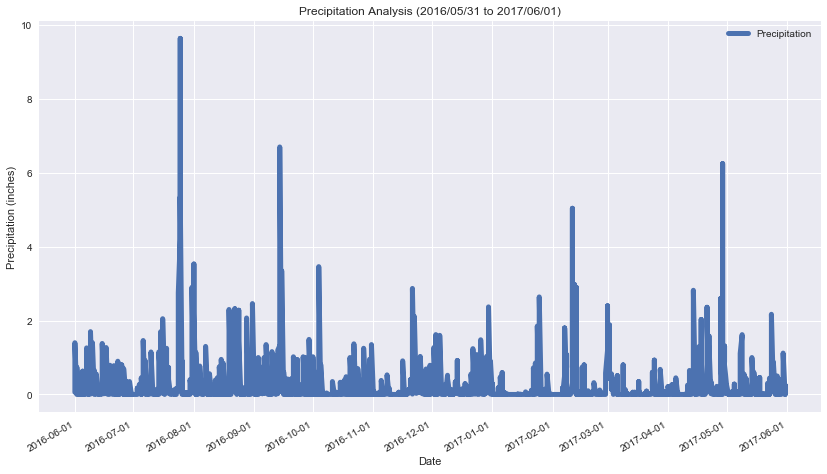

In [10]:
# Plot the results using the DataFrame `plot` method.
dates = prcp_df.index
x =[dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = prcp_df.prcp

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().set_xlabel('Date')
plt.gca().set_ylabel('Precipitation (inches)')
plt.plot(x,y,linewidth=5)
plt.gcf().autofmt_xdate()
plt.gca().legend(["Precipitation"])
plt.title("Precipitation Analysis (2016/05/31 to 2017/06/01)")
plt.gcf().set_size_inches(14, 8)
plt.gcf().savefig('images/precip.png')

plt.show()

In [11]:
# Statistical Summary  of Precipitation. 
prcp_df.describe()

,prcp
count,2056.000000
mean,0.216751
std,0.573145
min,0.000000
25%,0.000000
50%,0.020000
75%,0.160000
max,9.640000


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [12]:
#Design a query to calculate the total number of stations.
loc = session.query(Stations.station_id).count()
print("Total {} stations were used to gather data.".format(loc))

Total 9 stations were used to gather data.


In [13]:
#List the stations and observation counts in descending order
#Which station has the highest number of observations?

most_active_station = (session.query(Measurements.station, Stations.name, func.count(Measurements.measurement_id) ).\
    filter(Measurements.station == Stations.station ).  \
        group_by(Measurements.station).order_by(func.count(Measurements.measurement_id).desc())).statement
 
   
most_active_station_DF = pd.read_sql_query(most_active_station, session.bind)
most_active_station_DF = most_active_station_DF.rename(columns={'count_1':'Count'}, inplace=False)
most_active_station_DF

,station,name,Count
0,USC00519281,WAIHEE,2772
1,USC00513117,KANEOHE,2696
2,USC00519397,WAIKIKI,2685
3,USC00519523,WAIMANALO EXPERIMENTAL FARM,2572
4,USC00516128,MANOA LYON ARBO,2484
5,USC00514830,KUALOA RANCH HEADQUARTERS,1937
6,USC00511918,HONOLULU OBSERVATORY,1932
7,USC00517948,PEARL CITY,683
8,USC00518838,UPPER WAHIAWA,342


In [14]:
#Which station has the highest number of observations?
st= most_active_station_DF['station'][0]
n = most_active_station_DF['name'][0]
c = most_active_station_DF['Count'][0]
print("Busiest Station: ",st ,"in",n, "with ", c, " observations")
print()

Busiest Station:  USC00519281 in WAIHEE  with  2772  observations



In [15]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
#Filter by the station with the highest number of observations.
#Plot the results as a histogram with bins=12.

In [16]:
# Get laste record entry date for temp
last_entry_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_entry_date

('2017-08-23')

In [17]:
# 12 months before LAST record entry.
most_recent_1yr_entry = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(most_recent_1yr_entry)

2016-08-23


In [18]:
# query to pull the last year of precipitation data for the busiest station
temperature = (session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == st).\
    filter(Measurements.date > most_recent_1yr_entry).\
    order_by(Measurements.date)).statement

temperature_df= pd.read_sql_query(temperature, session.bind)
temperature_df[:5]

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


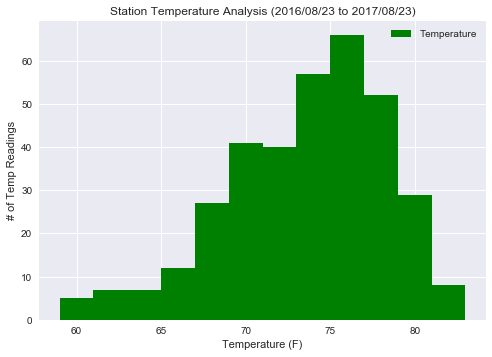

In [19]:
# Plot the results using the DataFrame `plot` method.
plt.hist(temperature_df['tobs'],bins=12, color='green')
plt.rcParams["figure.figsize"] = [10,6]

plt.xlabel('Temperature (F)')
plt.ylabel('# of Temp Readings')
plt.legend(["Temperature"])
plt.title("Station Temperature Analysis (2016/08/23 to 2017/08/23)")
plt.savefig('images/temp.png')

plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [20]:
def calc_temps(start_date, end_date):
    """min_temp, avg_temp, and max_temp for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        dataframe(min_temp, avg_temp, and max_temp)
    """
    res_temp = (session.query(func.min(Measurements.tobs).label("min_temp"), \
                         func.avg(Measurements.tobs).label("avg_temp"), \
                         func.max(Measurements.tobs).label("max_temp")).\
                         filter(Measurements.date >= start_date).\
                         filter(Measurements.date <= end_date)).statement
    
    temperature_df= pd.read_sql_query(res_temp, session.bind)
    
    return temperature_df

In [21]:
t_range = calc_temps('2017-08-14', '2017-08-29')
t_range

,min_temp,avg_temp,max_temp
0,70.0,78.277778,83.0


In [22]:
# calculate the min/max/avg from last year that matches my trip date
arrival_date= dt.date(2017, 2, 14)
leave_date = dt.date(2017, 2, 28)
one_year = dt.timedelta(days=365)
temp_avg = (calc_temps((arrival_date-one_year), (leave_date-one_year)))
temp_avg

,min_temp,avg_temp,max_temp
0,60.0,70.686747,80.0


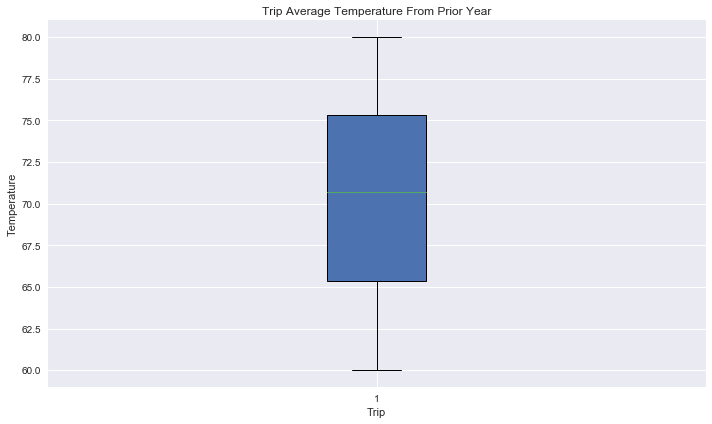

In [23]:
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temp_avg))
ax.boxplot(temp_avg, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.savefig('images/temp_Avg_box.png')
plt.show()

In [24]:
#Temperature Range during Trip duration
minTemp= temp_avg['min_temp'][0]
avgTemp = temp_avg['avg_temp'][0]
maxTemp = temp_avg['max_temp'][0]

/Users/rck/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


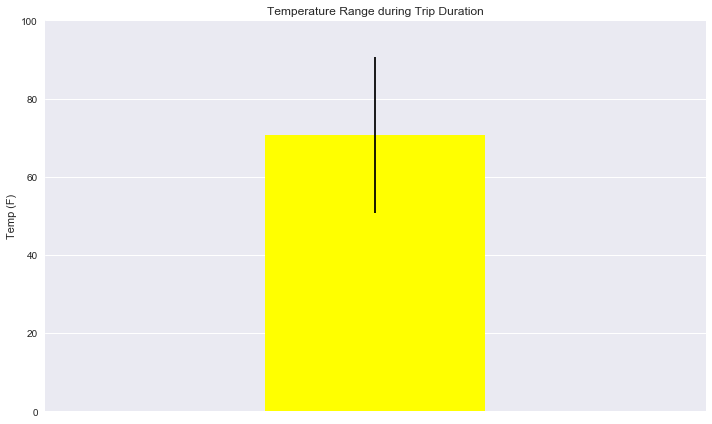

In [25]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

plt.bar( 1,avgTemp, color = 'Yellow', yerr = maxTemp-minTemp, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 100])
plt.axes().get_xaxis().set_visible(False)
plt.title('Temperature Range during Trip Duration')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('images/temp_Avg_bar.png')
plt.show()